## Fill-in value

In [1]:
# packages needed upload
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# train data file
df = pd.read_csv('/content/train.csv')
df.iloc[:5]

,id,date,speed
0,0,1/1/2017 0:00,43.002930
1,1,1/1/2017 1:00,46.118696
2,2,1/1/2017 2:00,44.294158
3,3,1/1/2017 3:00,41.067468
4,4,1/1/2017 4:00,46.448653


In [32]:
# maps the time columns to datetime dtype
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df.iloc[:5]

,id,date,speed
0,0,2017-01-01 00:00:00,43.002930
1,1,2017-01-01 01:00:00,46.118696
2,2,2017-01-01 02:00:00,44.294158
3,3,2017-01-01 03:00:00,41.067468
4,4,2017-01-01 04:00:00,46.448653


In [33]:
# generates a dateframe with datetime ranging from 2017/01/01 to 2018/12/31
import numpy as np

date_range = pd.date_range("2017-01-01 00:00:00", "2017-12-31 23:00:00", freq='1H').append(pd.date_range("2018-01-01 00:00:00","2018-12-31 23:00:00", freq='1H'))

df_total = pd.DataFrame(columns = ['date', 'speed'])
df_total['date'] = date_range
df_total['speed'] = np.nan
df_total.iloc[:5]

,date,speed
0,2017-01-01 00:00:00,NaN
1,2017-01-01 01:00:00,NaN
2,2017-01-01 02:00:00,NaN
3,2017-01-01 03:00:00,NaN
4,2017-01-01 04:00:00,NaN


In [34]:
# merge train data into a complete time range file to detect the missing value
df2 = pd.merge(df_total, df, on='date', how = 'left')
df2.iloc[:5]

,date,speed_x,id,speed_y
0,2017-01-01 00:00:00,NaN,0.0,43.002930
1,2017-01-01 01:00:00,NaN,1.0,46.118696
2,2017-01-01 02:00:00,NaN,2.0,44.294158
3,2017-01-01 03:00:00,NaN,3.0,41.067468
4,2017-01-01 04:00:00,NaN,4.0,46.448653


In [35]:
df2 = df2[['date','speed_y']]
df2.columns = ['date', 'speed']
df2.iloc[:5]

,date,speed
0,2017-01-01 00:00:00,43.002930
1,2017-01-01 01:00:00,46.118696
2,2017-01-01 02:00:00,44.294158
3,2017-01-01 03:00:00,41.067468
4,2017-01-01 04:00:00,46.448653


In [36]:
df2['date_hour'] = df2.date.map(lambda x: x.strftime('%Y-%m-%d-%H'))
temp = df2[['date_hour','speed']]
temp.iloc[:5]

,date_hour,speed
0,2017-01-01-00,43.002930
1,2017-01-01-01,46.118696
2,2017-01-01-02,44.294158
3,2017-01-01-03,41.067468
4,2017-01-01-04,46.448653


In [37]:
# detect the linear trending of the speed for each hour
from sklearn import linear_model

def nan_helper(y):
  return np.isnan(y), lambda z: z.nonzero()[0]

y = temp['speed'].values
nans, x = nan_helper(y)
regr = linear_model.LinearRegression()
regr.fit(x(~nans).reshape(-1,1), y[~nans].reshape(-1,1))
temp['date_trend'] = regr.predict(temp.index.values.reshape(-1,1)).ravel()
df2 = pd.merge(df2, temp[['date_trend','date_hour']], on='date_hour', how='left')
df2.iloc[:5]

,date,speed,date_hour,date_trend
0,2017-01-01 00:00:00,43.002930,2017-01-01-00,32.822900
1,2017-01-01 01:00:00,46.118696,2017-01-01-01,32.822894
2,2017-01-01 02:00:00,44.294158,2017-01-01-02,32.822888
3,2017-01-01 03:00:00,41.067468,2017-01-01-03,32.822883
4,2017-01-01 04:00:00,46.448653,2017-01-01-04,32.822877


In [38]:
df2.drop(['date_hour'],axis=1,inplace=True)
df2.columns = ['date','speed','date_trend']
df2.iloc[:5]

,date,speed,date_trend
0,2017-01-01 00:00:00,43.002930,32.822900
1,2017-01-01 01:00:00,46.118696,32.822894
2,2017-01-01 02:00:00,44.294158,32.822888
3,2017-01-01 03:00:00,41.067468,32.822883
4,2017-01-01 04:00:00,46.448653,32.822877


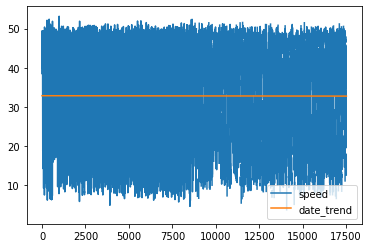

In [39]:
df2[['speed','date_trend']].plot()
plt.show()

In [40]:
# extract the time features
df2['speed'] = df2['speed'] - df2['date_trend']
df2['minute'] = df2['date'].dt.minute
df2['hour'] = df2['date'].dt.hour
df2['day'] = df2['date'].dt.day
df2['week_day'] = df2['date'].map(lambda x: x.weekday()+1)
df2['month'] = df2['date'].dt.month

df2.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month
0,2017-01-01 00:00:00,10.180030,32.822900,0,0,1,7,1
1,2017-01-01 01:00:00,13.295801,32.822894,0,1,1,7,1
2,2017-01-01 02:00:00,11.471270,32.822888,0,2,1,7,1
3,2017-01-01 03:00:00,8.244585,32.822883,0,3,1,7,1
4,2017-01-01 04:00:00,13.625776,32.822877,0,4,1,7,1


In [41]:
# add the vacation features
df2['speed_std'] = np.std(df2['speed'])
df2['speed'] = df2['speed'] / df2['speed_std']
df2.loc[df2['date'].isin(
    ['2017-01-02', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-01',
     '2017-05-03', '2017-05-30', '2017-07-01', '2017-10-02', '2017-10-05', '2017-10-28', '2017-12-25', '2017-12-26',
     '2018-01-02', '2018-01-28', '2018-01-30', '2018-01-31', '2018-04-04', '2018-04-14', '2018-04-15', '2018-04-17', '2018-05-01',
     '2018-05-03', '2018-05-30', '2018-07-01', '2018-10-02', '2018-10-05', '2018-10-28', '2018-12-25', '2018-12-26']), 'vacation'] = 1

df2.loc[~df2['date'].isin(
    ['2017-01-02', '2017-01-28', '2017-01-30', '2017-01-31', '2017-04-04', '2017-04-14', '2017-04-15', '2017-04-17', '2017-05-01',
     '2017-05-03', '2017-05-30', '2017-07-01', '2017-10-02', '2017-10-05', '2017-10-28', '2017-12-25', '2017-12-26',
     '2018-01-02', '2018-01-28', '2018-01-30', '2018-01-31', '2018-04-04', '2018-04-14', '2018-04-15', '2018-04-17', '2018-05-01',
     '2018-05-03', '2018-05-30', '2018-07-01', '2018-10-02', '2018-10-05', '2018-10-28', '2018-12-25', '2018-12-26']), 'vacation'] = 0

df2.iloc[:5]                                  

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation
0,2017-01-01 00:00:00,0.750004,32.822900,0,0,1,7,1,13.5733,0.0
1,2017-01-01 01:00:00,0.979556,32.822894,0,1,1,7,1,13.5733,0.0
2,2017-01-01 02:00:00,0.845135,32.822888,0,2,1,7,1,13.5733,0.0
3,2017-01-01 03:00:00,0.607412,32.822883,0,3,1,7,1,13.5733,0.0
4,2017-01-01 04:00:00,1.003866,32.822877,0,4,1,7,1,13.5733,0.0


In [42]:
# detect the week_day feature
df2.loc[df2['week_day'].isin([1, 2, 3, 4, 5]), 'day_of_week'] = 1
df2.loc[df2['week_day'] == 6, 'day_of_week'] = 2
df2.loc[df2['week_day'] == 7, 'day_of_week'] = 3

df2.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week
0,2017-01-01 00:00:00,0.750004,32.822900,0,0,1,7,1,13.5733,0.0,3.0
1,2017-01-01 01:00:00,0.979556,32.822894,0,1,1,7,1,13.5733,0.0,3.0
2,2017-01-01 02:00:00,0.845135,32.822888,0,2,1,7,1,13.5733,0.0,3.0
3,2017-01-01 03:00:00,0.607412,32.822883,0,3,1,7,1,13.5733,0.0,3.0
4,2017-01-01 04:00:00,1.003866,32.822877,0,4,1,7,1,13.5733,0.0,3.0


In [43]:
# detect the month trend
df2.loc[df2['month'].isin([10,11,12,1]), 'month_of_year'] = 1
df2.loc[df2['month'] == 9, 'month_of_year'] = 2
df2.loc[df2['month'] == 8, 'month_of_year'] = 3
df2.loc[df2['month'].isin([3,4,5,7]), 'month_of_year'] = 4
df2.loc[df2['month'] == 2, 'month_of_year'] = 5

df2.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year
0,2017-01-01 00:00:00,0.750004,32.822900,0,0,1,7,1,13.5733,0.0,3.0,1.0
1,2017-01-01 01:00:00,0.979556,32.822894,0,1,1,7,1,13.5733,0.0,3.0,1.0
2,2017-01-01 02:00:00,0.845135,32.822888,0,2,1,7,1,13.5733,0.0,3.0,1.0
3,2017-01-01 03:00:00,0.607412,32.822883,0,3,1,7,1,13.5733,0.0,3.0,1.0
4,2017-01-01 04:00:00,1.003866,32.822877,0,4,1,7,1,13.5733,0.0,3.0,1.0


In [47]:
# detect the hour trend
df2.loc[df2['hour'].isin([22,23,0,1,2,3,4,5]), 'hour_of_day'] = 1
df2.loc[df2['hour'].isin([6,7,8,9,10]), 'hour_of_day'] = 2
df2.loc[df2['hour'].isin([11,12,13,14,15,16,17]), 'hour_of_day'] = 3
df2.loc[df2['hour'].isin([18,19,20,21]), 'hour_of_day'] = 4

df2.loc[df2['hour'].isin([7,8,9]), 'rush_hour'] = 1
df2.loc[df2['hour'].isin([17,18,19]), 'rush_hour'] = 1
df2.loc[~df2['hour'].isin([7,8,9,17,18,19]), 'rush_hour'] = 0

df2.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,rush_hour
0,2017-01-01 00:00:00,0.750004,32.822900,0,0,1,7,1,13.5733,0.0,3.0,1.0,1.0,0.0
1,2017-01-01 01:00:00,0.979556,32.822894,0,1,1,7,1,13.5733,0.0,3.0,1.0,1.0,0.0
2,2017-01-01 02:00:00,0.845135,32.822888,0,2,1,7,1,13.5733,0.0,3.0,1.0,1.0,0.0
3,2017-01-01 03:00:00,0.607412,32.822883,0,3,1,7,1,13.5733,0.0,3.0,1.0,1.0,0.0
4,2017-01-01 04:00:00,1.003866,32.822877,0,4,1,7,1,13.5733,0.0,3.0,1.0,1.0,0.0


In [48]:
# determine the train features
train_data = df2

feature = train_data.columns.values.tolist()
train_feature = [x for x in feature if x not in ['date','speed','speed_std','date_trend']]
# train_feature = [x for x in feature if x not in ['date','speed','speed_std','date_trend', 'minute', 'hour', 'day', 'week_day', 'month']]

train_df = train_data.loc[~train_data['speed'].isnull()]
test_df = train_data.loc[train_data['speed'].isnull()].copy()
print(train_feature)

['minute', 'hour', 'day', 'week_day', 'month', 'vacation', 'rush_hour']


In [49]:
test_df.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,rush_hour
382,2017-01-16 22:00:00,NaN,32.820711,0,22,16,1,1,13.5733,0.0,1.0,1.0,1.0,0.0
383,2017-01-16 23:00:00,NaN,32.820705,0,23,16,1,1,13.5733,0.0,1.0,1.0,1.0,0.0
384,2017-01-17 00:00:00,NaN,32.820700,0,0,17,2,1,13.5733,0.0,1.0,1.0,1.0,0.0
385,2017-01-17 01:00:00,NaN,32.820694,0,1,17,2,1,13.5733,0.0,1.0,1.0,1.0,0.0
411,2017-01-18 03:00:00,NaN,32.820545,0,3,18,3,1,13.5733,0.0,1.0,1.0,1.0,0.0


In [50]:
from sklearn.model_selection import train_test_split

X = train_df[train_feature].values
y = train_df['speed'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
eval_set = [(X_test, y_test)]

print(train_feature)

['minute', 'hour', 'day', 'week_day', 'month', 'vacation', 'rush_hour']


In [51]:
# train the xgboost model
from xgboost.sklearn import XGBRegressor

params = {
    'learning_rate': 0.1,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'max_depth': 12,
    'min_child_weight': 1,
    'reg_alpha': 1,
    'gamma': 0
}

regressor = XGBRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                             booster='gbtree', objective='reg:linear', n_jobs=-1, subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'], random_state=0,
                             max_depth=params['max_depth'], gamma=params['gamma'],
                             min_child_weight=params['min_child_weight'], reg_alpha=params['reg_alpha'])

regressor.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_set=eval_set)

[11:29:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.0173
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.924848
[2]	validation_0-rmse:0.88553
[3]	validation_0-rmse:0.820072
[4]	validation_0-rmse:0.749315
[5]	validation_0-rmse:0.722282
[6]	validation_0-rmse:0.705464
[7]	validation_0-rmse:0.685112
[8]	validation_0-rmse:0.640449
[9]	validation_0-rmse:0.601816
[10]	validation_0-rmse:0.591972
[11]	validation_0-rmse:0.559217
[12]	validation_0-rmse:0.531103
[13]	validation_0-rmse:0.52338
[14]	validation_0-rmse:0.487732
[15]	validation_0-rmse:0.481614
[16]	validation_0-rmse:0.477521
[17]	validation_0-rmse:0.456061
[18]	validation_0-rmse:0.452314
[19]	validation_0-rmse:0.450669
[20]	validation_0-rmse:0.448129
[21]	validation_0-rmse:0.44561
[22]	validation_0-rmse:0.443879
[23]	validation_0-rmse:0.42698
[24]	validation_0-rmse:0.403754
[25]	validation_0-rmse:0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=12, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.8, verbosity=1)

In [52]:
# use the trained model to predict in the test data
test_df['prediction'] = regressor.predict(test_df[train_feature].values)
test_df.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,rush_hour,prediction
382,2017-01-16 22:00:00,NaN,32.820711,0,22,16,1,1,13.5733,0.0,1.0,1.0,1.0,0.0,0.529895
383,2017-01-16 23:00:00,NaN,32.820705,0,23,16,1,1,13.5733,0.0,1.0,1.0,1.0,0.0,0.840743
384,2017-01-17 00:00:00,NaN,32.820700,0,0,17,2,1,13.5733,0.0,1.0,1.0,1.0,0.0,1.099647
385,2017-01-17 01:00:00,NaN,32.820694,0,1,17,2,1,13.5733,0.0,1.0,1.0,1.0,0.0,1.132502
411,2017-01-18 03:00:00,NaN,32.820545,0,3,18,3,1,13.5733,0.0,1.0,1.0,1.0,0.0,1.123181


In [53]:
df2 = pd.merge(df2, test_df[['date','prediction']], on=['date'],how='left')
df2.iloc[-5:]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,rush_hour,prediction
17515,2018-12-31 19:00:00,NaN,32.722539,0,19,31,1,12,13.5733,0.0,1.0,1.0,4.0,1.0,-0.263425
17516,2018-12-31 20:00:00,0.579936,32.722534,0,20,31,1,12,13.5733,0.0,1.0,1.0,4.0,0.0,NaN
17517,2018-12-31 21:00:00,NaN,32.722528,0,21,31,1,12,13.5733,0.0,1.0,1.0,4.0,0.0,0.930936
17518,2018-12-31 22:00:00,NaN,32.722522,0,22,31,1,12,13.5733,0.0,1.0,1.0,1.0,0.0,0.538615
17519,2018-12-31 23:00:00,NaN,32.722517,0,23,31,1,12,13.5733,0.0,1.0,1.0,1.0,0.0,0.736008


In [54]:
# calculate the final speed
df2['imputationa1'] = df2['speed'].isnull()
df2['speed'] = df2['speed'].fillna(value=df2['prediction'])
df2['speed'] = (df2['speed'] * np.array(df2['speed_std']) + np.array(df2['date_trend']))
df2[-5:]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,rush_hour,prediction,imputationa1
17515,2018-12-31 19:00:00,29.146987,32.722539,0,19,31,1,12,13.5733,0.0,1.0,1.0,4.0,1.0,-0.263425,True
17516,2018-12-31 20:00:00,40.594183,32.722534,0,20,31,1,12,13.5733,0.0,1.0,1.0,4.0,0.0,NaN,False
17517,2018-12-31 21:00:00,45.358396,32.722528,0,21,31,1,12,13.5733,0.0,1.0,1.0,4.0,0.0,0.930936,True
17518,2018-12-31 22:00:00,40.033299,32.722522,0,22,31,1,12,13.5733,0.0,1.0,1.0,1.0,0.0,0.538615,True
17519,2018-12-31 23:00:00,42.712580,32.722517,0,23,31,1,12,13.5733,0.0,1.0,1.0,1.0,0.0,0.736008,True


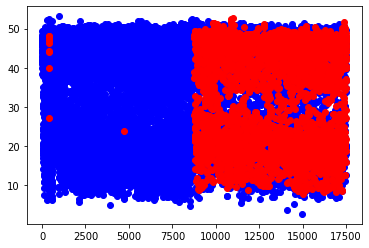

In [55]:
# visualize the prediction results
temp = df2.loc[df2['imputationa1'] == False]
tmp = df2.loc[df2['imputationa1'] == True]
plt.scatter(temp.index, temp['speed'], c='b')
plt.scatter(tmp.index, tmp['speed'], c='r')
plt.show()

In [56]:
df2.to_csv('prediction_1205_1.csv')

## XGBOOST

In [ ]:
df2.iloc[-5:]
store_df = df2

In [ ]:
def create_lagging(df, df_original, i):
  df1 = df_original.copy()
  df1['date'] = df1['date'] + pd.DateOffset(hours=i * 1)
  df1 = df1.rename(columns={'speed': 'lagging' + str(i)})
  df2 = pd.merge(df, df1[['date', 'lagging' + str(i)]],
                  on='date',
                  how='left')
  return df2

lagging = 5
df = create_lagging(df2, df2, 1)
for i in range(2, lagging + 1):
  df = create_lagging(df, df2, i)

df.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,prediction,imputationa1,lagging1,lagging2,lagging3,lagging4,lagging5
0,2017-01-01 00:00:00,43.002930,32.822900,0,0,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00:00,46.118696,32.822894,0,1,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,43.002930,NaN,NaN,NaN,NaN
2,2017-01-01 02:00:00,44.294158,32.822888,0,2,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,46.118696,43.002930,NaN,NaN,NaN
3,2017-01-01 03:00:00,41.067468,32.822883,0,3,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,44.294158,46.118696,43.002930,NaN,NaN
4,2017-01-01 04:00:00,46.448653,32.822877,0,4,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,41.067468,44.294158,46.118696,43.00293,NaN


In [ ]:
df2.iloc[20:30]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,prediction,imputationa1
20,2017-01-01 20:00:00,46.444756,32.822785,0,20,1,7,1,13.5733,0.0,3.0,1.0,4.0,NaN,False
21,2017-01-01 21:00:00,41.981908,32.822780,0,21,1,7,1,13.5733,0.0,3.0,1.0,4.0,NaN,False
22,2017-01-01 22:00:00,39.817240,32.822774,0,22,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False
23,2017-01-01 23:00:00,44.277821,32.822768,0,23,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False
24,2017-01-02 00:00:00,47.621563,32.822762,0,0,2,1,1,13.5733,1.0,1.0,1.0,1.0,NaN,False
25,2017-01-02 01:00:00,47.070161,32.822757,0,1,2,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False
26,2017-01-02 02:00:00,46.894923,32.822751,0,2,2,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False
27,2017-01-02 03:00:00,47.061395,32.822745,0,3,2,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False
28,2017-01-02 04:00:00,47.016156,32.822740,0,4,2,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False
29,2017-01-02 05:00:00,44.826296,32.822734,0,5,2,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False


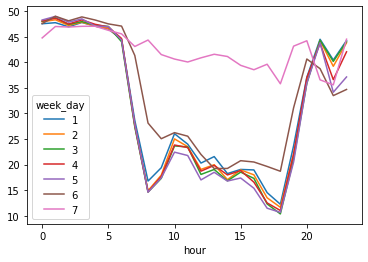

In [ ]:
df2.loc[df['date'].dt.month.isin(range(1,13))].groupby(['hour', 'week_day'])[
    'speed'].mean().unstack().plot()
plt.show()

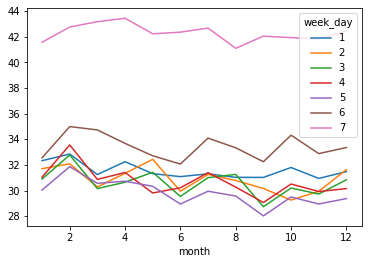

In [ ]:
df2.loc[df['date'].dt.month.isin(range(1,13))].groupby(['month', 'week_day'])[
    'speed'].mean().unstack().plot()
plt.show()

In [ ]:
df2.loc[df2['week_day'].isin([1, 2, 3, 4, 5]), 'day_of_week'] = 1
df2.loc[df2['week_day'] == 6, 'day_of_week'] = 2
df2.loc[df2['week_day'] == 7, 'day_of_week'] = 3

df2.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,prediction,imputationa1,day_of_week
0,2017-01-01 00:00:00,43.002930,32.822900,0,0,1,7,1,13.5733,0.0,NaN,False,3.0
1,2017-01-01 01:00:00,46.118696,32.822894,0,1,1,7,1,13.5733,0.0,NaN,False,3.0
2,2017-01-01 02:00:00,44.294158,32.822888,0,2,1,7,1,13.5733,0.0,NaN,False,3.0
3,2017-01-01 03:00:00,41.067468,32.822883,0,3,1,7,1,13.5733,0.0,NaN,False,3.0
4,2017-01-01 04:00:00,46.448653,32.822877,0,4,1,7,1,13.5733,0.0,NaN,False,3.0


In [ ]:
df2.loc[df2['month'].isin([10,11,12,1]), 'month_of_year'] = 1
df2.loc[df2['month'] == 9, 'month_of_year'] = 2
df2.loc[df2['month'] == 8, 'month_of_year'] = 3
df2.loc[df2['month'].isin([3,4,5,7]), 'month_of_year'] = 4
df2.loc[df2['month'] == 2, 'month_of_year'] = 5

df2.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,prediction,imputationa1,day_of_week,month_of_year
0,2017-01-01 00:00:00,43.002930,32.822900,0,0,1,7,1,13.5733,0.0,NaN,False,3.0,1.0
1,2017-01-01 01:00:00,46.118696,32.822894,0,1,1,7,1,13.5733,0.0,NaN,False,3.0,1.0
2,2017-01-01 02:00:00,44.294158,32.822888,0,2,1,7,1,13.5733,0.0,NaN,False,3.0,1.0
3,2017-01-01 03:00:00,41.067468,32.822883,0,3,1,7,1,13.5733,0.0,NaN,False,3.0,1.0
4,2017-01-01 04:00:00,46.448653,32.822877,0,4,1,7,1,13.5733,0.0,NaN,False,3.0,1.0


In [ ]:
df2.loc[df2['hour'].isin([22,23,0,1,2,3,4,5]), 'hour_of_day'] = 1
df2.loc[df2['hour'].isin([6,7,8,9,10]), 'hour_of_day'] = 2
df2.loc[df2['hour'].isin([11,12,13,14,15,16,17]), 'hour_of_day'] = 3
df2.loc[df2['hour'].isin([18,19,20,21]), 'hour_of_day'] = 4

df2.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,prediction,imputationa1,day_of_week,month_of_year,hour_of_day
0,2017-01-01 00:00:00,43.002930,32.822900,0,0,1,7,1,13.5733,0.0,NaN,False,3.0,1.0,1.0
1,2017-01-01 01:00:00,46.118696,32.822894,0,1,1,7,1,13.5733,0.0,NaN,False,3.0,1.0,1.0
2,2017-01-01 02:00:00,44.294158,32.822888,0,2,1,7,1,13.5733,0.0,NaN,False,3.0,1.0,1.0
3,2017-01-01 03:00:00,41.067468,32.822883,0,3,1,7,1,13.5733,0.0,NaN,False,3.0,1.0,1.0
4,2017-01-01 04:00:00,46.448653,32.822877,0,4,1,7,1,13.5733,0.0,NaN,False,3.0,1.0,1.0


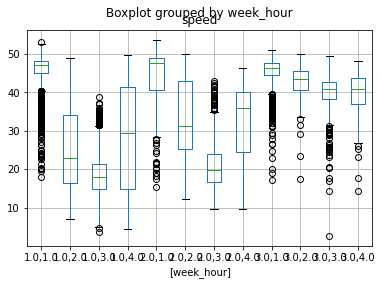

In [ ]:
df2['week_hour'] = df2["day_of_week"].astype('str') + "," + df2["hour_of_day"].astype('str')
df2.boxplot(by=['week_hour'], column='speed')
plt.show()

In [ ]:
df2.loc[df2['date'].isin(
    ['2018-01-02', '2018-01-28', '2018-01-30', '2018-01-31', '2018-04-04', '2018-04-14', '2018-04-15', '2018-04-17', '2018-05-01',
     '2018-05-03', '2018-05-30', '2018-07-01', '2018-10-02', '2018-10-05', '2018-10-28', '2018-12-25', '2018-12-26']), 'vacation'] = 1

df2.loc[~df2['date'].isin(
    ['2018-01-02', '2018-01-28', '2018-01-30', '2018-01-31', '2018-04-04', '2018-04-14', '2018-04-15', '2018-04-17', '2018-05-01',
     '2018-05-03', '2018-05-30', '2018-07-01', '2018-10-02', '2018-10-05', '2018-10-28', '2018-12-25', '2018-12-26']), 'vacation'] = 0

df2.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,prediction,imputationa1
0,2017-01-01 00:00:00,43.002930,32.822900,0,0,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False
1,2017-01-01 01:00:00,46.118696,32.822894,0,1,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False
2,2017-01-01 02:00:00,44.294158,32.822888,0,2,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False
3,2017-01-01 03:00:00,41.067468,32.822883,0,3,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False
4,2017-01-01 04:00:00,46.448653,32.822877,0,4,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False


In [ ]:
df2 = pd.merge(df2,df[['date','lagging1','lagging2','lagging3','lagging4','lagging5']],on='date',how='left')
df2.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,prediction,imputationa1,lagging1,lagging2,lagging3,lagging4,lagging5
0,2017-01-01 00:00:00,43.002930,32.822900,0,0,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00:00,46.118696,32.822894,0,1,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,43.002930,NaN,NaN,NaN,NaN
2,2017-01-01 02:00:00,44.294158,32.822888,0,2,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,46.118696,43.002930,NaN,NaN,NaN
3,2017-01-01 03:00:00,41.067468,32.822883,0,3,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,44.294158,46.118696,43.002930,NaN,NaN
4,2017-01-01 04:00:00,46.448653,32.822877,0,4,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,41.067468,44.294158,46.118696,43.00293,NaN


In [ ]:
from sklearn.externals import joblib
from sklearn.model_selection import ParameterGrid

train_df = df2.loc[df2['date'] < pd.to_datetime('2018-01-01')]
train_df.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,prediction,imputationa1,lagging1,lagging2,lagging3,lagging4,lagging5
0,2017-01-01 00:00:00,43.002930,32.822900,0,0,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 01:00:00,46.118696,32.822894,0,1,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,43.002930,NaN,NaN,NaN,NaN
2,2017-01-01 02:00:00,44.294158,32.822888,0,2,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,46.118696,43.002930,NaN,NaN,NaN
3,2017-01-01 03:00:00,41.067468,32.822883,0,3,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,44.294158,46.118696,43.002930,NaN,NaN
4,2017-01-01 04:00:00,46.448653,32.822877,0,4,1,7,1,13.5733,0.0,3.0,1.0,1.0,NaN,False,41.067468,44.294158,46.118696,43.00293,NaN


In [ ]:
train_df = train_df.dropna()

feature = train_df.columns.values.tolist()
# train_feature = [x for x in feature if x not in ['date', 'speed', 'date_trend', 'minute', 'hour', 
#                                                  'day', 'week_day', 'month', 'speed_std',
#                                                  'prediction', 'imputationa1','week_hour']]
train_feature = [x for x in feature if x not in ['date', 'speed', 'date_trend', 'minute', 'week_day', 'month', 'vacation',
                                                 'day', 'speed_std',
                                                 'prediction', 'imputationa1','week_hour']]

X = train_df[train_feature].values
y = train_df['speed'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

print(train_feature)

['hour', 'day_of_week', 'month_of_year', 'hour_of_day', 'lagging1', 'lagging2', 'lagging3', 'lagging4', 'lagging5']


In [ ]:
test_df = df2.loc[df2['date'] >= pd.to_datetime('2018-01-01')]
test_df.iloc[:5]

,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,prediction,imputationa1,lagging1,lagging2,lagging3,lagging4,lagging5
8760,2018-01-01 00:00:00,43.707252,32.772705,0,0,1,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False,45.894518,42.754849,43.059179,46.428155,44.742372
8761,2018-01-01 01:00:00,47.648155,32.772700,0,1,1,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False,43.707252,45.894518,42.754849,43.059179,46.428155
8762,2018-01-01 02:00:00,47.769725,32.772694,0,2,1,1,1,13.5733,0.0,1.0,1.0,1.0,1.104892,True,47.648155,43.707252,45.894518,42.754849,43.059179
8763,2018-01-01 03:00:00,50.626977,32.772688,0,3,1,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False,47.769725,47.648155,43.707252,45.894518,42.754849
8764,2018-01-01 04:00:00,48.740828,32.772682,0,4,1,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False,50.626977,47.769725,47.648155,43.707252,45.894518


In [ ]:
def cross_valid(regressor, bucket, lagging):
  valid_loss = []
  last = [[] for i in range(len(bucket[bucket.keys()[0]]))]
  for time_series in sorted(bucket.keys(), key=float):
    if time_series >= 120:
      if int(time_series) in range(120, 120 + lagging * 2, 2):
        last = np.concatenate((last, np.array(bucket[time_series], dtype=float)[:, -1].reshape(-1, 1)), axis=1)
      else:
        batch = np.array(bucket[time_series], dtype=float)
        y = batch[:, -1]
        batch = np.delete(batch, -1, axis=1)
        batch = np.concatenate((batch, last), axis=1)
        y_pre = regressor.predict(batch)
        last = np.delete(last, 0, axis=1)
        last = np.concatenate((last, y_pre.reshape(-1, 1)), axis=1)
        loss = np.mean(abs(np.expm1(y) - np.expm1(y_pre)) / np.expm1(y))
        valid_loss.append(loss)
  # print 'day: %d loss: %f' % (int(day), day_loss)
  return np.mean(valid_loss)


def mape_ln(y, d):
  c = d.get_label()
  result = np.sum(np.abs((np.expm1(y) - np.expm1(c)) / np.expm1(c))) / len(c)
  return "mape", result

In [ ]:
eval_set = [(X_test, y_test)]

params = {
    'learning_rate': 0.2,
    'n_estimators': 1000,
    'subsample': 0.6,
    'colsample_bytree': 0.8,
    'max_depth': 15,
    'min_child_weight': 1,
    'reg_alpha': 2,
    'gamma': 0
}

regressor2 = XGBRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                              booster='gbtree', objective='reg:linear', n_jobs=-1, subsample=params['subsample'],
                              colsample_bytree=params['colsample_bytree'], random_state=0,
                              max_depth=params['max_depth'], gamma=params['gamma'],
                              min_child_weight=params['min_child_weight'], reg_alpha=params['reg_alpha'])

regressor2.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric=mape_ln,
                  eval_set=eval_set)

[04:51:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:41.2693	validation_0-mape:1
Multiple eval metrics have been passed: 'validation_0-mape' will be used for early stopping.

Will train until validation_0-mape hasn't improved in 10 rounds.
[1]	validation_0-rmse:35.2151	validation_0-mape:1
[2]	validation_0-rmse:30.0764	validation_0-mape:1
[3]	validation_0-rmse:25.4504	validation_0-mape:1
[4]	validation_0-rmse:21.6327	validation_0-mape:1
[5]	validation_0-rmse:18.8724	validation_0-mape:1
[6]	validation_0-rmse:16.0203	validation_0-mape:1
[7]	validation_0-rmse:13.5287	validation_0-mape:0.999999
[8]	validation_0-rmse:11.4524	validation_0-mape:0.999989
[9]	validation_0-rmse:9.52866	validation_0-mape:0.999927
[10]	validation_0-rmse:8.0945	validation_0-mape:0.999695
[11]	validation_0-rmse:7.98182	validation_0-mape:0.999658
[12]	validation_0-rmse:7.32694	validation_0-mape:0.999342
[13]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=2, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.6, verbosity=1)

In [ ]:
test_df['prediction_xgb'] = regressor2.predict(test_df[train_feature].values)
# test_df['prediction_xgb'] = (test_df['prediction_xgb'] * np.array(test_df['speed_std']) + np.array(test_df['date_trend']))
test_df.iloc[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,date,speed,date_trend,minute,hour,day,week_day,month,speed_std,vacation,day_of_week,month_of_year,hour_of_day,prediction,imputationa1,lagging1,lagging2,lagging3,lagging4,lagging5,prediction_xgb
8760,2018-01-01 00:00:00,43.707252,32.772705,0,0,1,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False,45.894518,42.754849,43.059179,46.428155,44.742372,48.005142
8761,2018-01-01 01:00:00,47.648155,32.772700,0,1,1,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False,43.707252,45.894518,42.754849,43.059179,46.428155,43.559784
8762,2018-01-01 02:00:00,47.769725,32.772694,0,2,1,1,1,13.5733,0.0,1.0,1.0,1.0,1.104892,True,47.648155,43.707252,45.894518,42.754849,43.059179,48.005142
8763,2018-01-01 03:00:00,50.626977,32.772688,0,3,1,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False,47.769725,47.648155,43.707252,45.894518,42.754849,48.005142
8764,2018-01-01 04:00:00,48.740828,32.772682,0,4,1,1,1,13.5733,0.0,1.0,1.0,1.0,NaN,False,50.626977,47.769725,47.648155,43.707252,45.894518,46.925186
8765,2018-01-01 05:00:00,47.538994,32.772677,0,5,1,1,1,13.5733,0.0,1.0,1.0,1.0,1.087894,True,48.740828,50.626977,47.769725,47.648155,43.707252,46.925186
8766,2018-01-01 06:00:00,46.179884,32.772671,0,6,1,1,1,13.5733,0.0,1.0,1.0,2.0,NaN,False,47.538994,48.740828,50.626977,47.769725,47.648155,42.045650
8767,2018-01-01 07:00:00,37.647258,32.772665,0,7,1,1,1,13.5733,0.0,1.0,1.0,2.0,0.359131,True,46.179884,47.538994,48.740828,50.626977,47.769725,35.213768
8768,2018-01-01 08:00:00,28.576218,32.772660,0,8,1,1,1,13.5733,0.0,1.0,1.0,2.0,-0.309169,True,37.647258,46.179884,47.538994,48.740828,50.626977,30.768398
8769,2018-01-01 09:00:00,36.009622,32.772654,0,9,1,1,1,13.5733,0.0,1.0,1.0,2.0,NaN,False,28.576218,37.647258,46.179884,47.538994,48.740828,36.614212


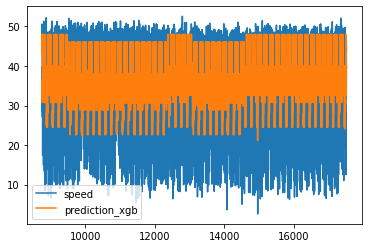

In [ ]:
plot_df = pd.DataFrame(test_df,columns=['speed','prediction_xgb'])
plot_df.plot()
plt.show()

In [ ]:
test_df.to_csv('prediction_1204_1.csv')